In [1]:
import os
import math
import json
import copy
import time
import deepbrain
import numpy as np 
import pandas as pd
import nibabel as nib
from tqdm import tqdm
from mayavi import mlab
import SimpleITK as sitk
import nibabel.processing
from nilearn import plotting
from pyecharts import Pie, Bar
from skimage import morphology
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from sklearn.mixture import GaussianMixture

from intensity_normalization.normalize import gmm, whitestripe,zscore
from intensity_normalization.utilities import io, hist

from util_tool.normalisation  import ws_norm


In [2]:
def extract_IXI_dataset():
    file_name_list = [each for each in os.listdir('IXI') if not each.startswith('.')]
    for n,each in tqdm(enumerate(file_name_list, 1)):
        proxy = nib.load(os.path.join('IXI', each), keep_file_open=False)
        three_d_data = np.array(proxy.dataobj)
        extracted_brain = extract_brain(three_d_data)
        nib_obj = nib.nifti1.Nifti1Image(extracted_brain, affine=proxy.affine)
        nib_obj.to_filename(os.path.join('Extracted_IXI', each))

In [3]:
def extract_brain(img):
    def remove_small_objects(img):
        binary = copy.copy(img)
        binary[binary>0] = 1
        labels = morphology.label(binary)
        labels_num = [len(labels[labels==each]) for each in np.unique(labels)]
        rank = np.argsort(np.argsort(labels_num))
        index = list(rank).index(len(rank)-2)
        new_img = copy.copy(img)
        new_img[labels!=index] = 0
        return new_img
    copy_img = copy.copy(img)
    extractor = deepbrain.Extractor()
    prob = extractor.run(copy_img)
    copy_img[prob<0.5] = 0
    extracted_brain = remove_small_objects(copy_img)
    return extracted_brain

In [4]:
def check_MRI_resolution(full_name):
    agent = nib.load(full_name,keep_file_open=False)
    pixdim = agent.header['pixdim']
    if np.all(pixdim[1:4] == np.ones(3)):
        print(full_name,'right')
        return True
    else:
        print(full_name,'wrong',pixdim[1:4])
        return False
        
def check_dir_MRI_resolution(directory):
    file_names = os.listdir(os.path.join('raw',directory))
    for file_name in file_names:
        full_name = os.path.join('raw', directory, file_name)
        check_MRI_resolution(full_name)
        


In [5]:
def resample_resolution():
    directories = [each for each in os.listdir('raw') if '.' not in each]
    for directory in directories:
        print(f'Start resample {directory}')
        start = time.time()
        files = [each for each in os.listdir(os.path.join('raw', directory)) if each.endswith('.nii')]
        for file in tqdm(files, total=len(files)):
            full_path = os.path.join('raw', directory, file)
            to_dir = os.path.join('resample', directory)
            to_path = os.path.join(to_dir, file)
            ori_img = nib.load(full_path,keep_file_open=False)
            pixdim = ori_img.header['pixdim']
            if not os.path.exists(to_dir):
                    os.mkdir(to_dir)
            if not np.all(pixdim[1:4] == np.ones(3)):
                resampled_img = nibabel.processing.resample_to_output(ori_img, [1,1,1])
                nibabel.save(resampled_img, to_path)
            else:
                nibabel.save(ori_img, to_path)
        end = time.time()
        print(f'Cost time:{(end-start)/60} min')
                
                
                

In [6]:
def compare_gmm_histogram(path_list):
    total_num = len(path_list)*2
    row = 2
    col = math.ceil(total_num / row)
    plt.figure(figsize=(40,10))
    for n,path in enumerate(path_list,1):
        proxy = nib.load(path, keep_file_open=False)
        data = np.array(proxy.dataobj)
        normalised = gmm.gmm_normalize(proxy)
        normalised_data = np.array(normalised.dataobj)
        plt.subplot(row,col,n)
        plt.title(path.split('/')[-2] + ',Original')
        temp = plt.hist(data[(data>1)], density=True,bins=100)
        plt.subplot(row,col,n+col)
        plt.title(path.split('/')[-2] + ',Normalised')
        temp = plt.hist(normalised_data[normalised_data>0], density=True, bins=np.linspace(0,1.5,101))

In [7]:
def compare_white_stripe_histogram(path_list):
    total_num = len(path_list)*2
    row = 2
    col = math.ceil(total_num / row)
    plt.figure(figsize=(40,10))
    plt.suptitle('White stripe normalisation',fontsize=30)
    for n,path in enumerate(path_list,1):
        proxy = nib.load(path, keep_file_open=False)
        data = np.array(proxy.dataobj)
        normalised = ws_norm(proxy)
        normalised_data = np.array(normalised.dataobj)
        plt.subplot(row,col,n)
        plt.title(path.split('/')[-2] + ',Original')
        temp = plt.hist(data[(data>0.1)],density=True,bins=100)
        plt.subplot(row,col,n+col)
        plt.title(path.split('/')[-2] + ',Normalised')
        temp = plt.hist(normalised_data[normalised_data>np.mean(normalised_data)],density=True, bins=100)


In [8]:
def ws_normalisation(img):
    indices = whitestripe.whitestripe(img, 'T1', mask=None)
    normalized = whitestripe.whitestripe_norm(img, indices)
    return normalized

In [16]:
def home_made_norm(agent):
    data = np.array(agent.dataobj)
    brain = np.expand_dims(data[data > np.mean(data)].flatten(), 1)
    gmm = GaussianMixture(3)
    gmm.fit(brain)
    means = sorted(gmm.means_.T.squeeze())
    grey_matter, white_matter = means[1], means[2]
    data = data/white_matter
    C = grey_matter / white_matter
    a = (0.75 - C ** 2) / (C - C ** 2)
    data[data < 1] = a * data[data < 1] + (1 - a) * data[data < 1]**2
    return nib.Nifti1Image(data, agent.affine, agent.header)

In [10]:
def dictify(name, normalisation='white_stripe'):
    data = {}
    for category in [each for each in os.listdir(name) if not each.startswith('.')]:
        file_names = [each for each in os.listdir(os.path.join(name, category)) if each.endswith('.gz')]
        data_frame = pd.read_csv(os.path.join('demographic',category+'.csv'))
        file_list = []
        for n,file_name in tqdm(enumerate(file_names), total=len(file_names)):
            file_dict = {}
            full_name = os.path.join(name, category, file_name)
            proxy = nib.load(full_name, keep_file_open=False)
            if normalisation == 'gmm':
                normalised = gmm.gmm_normalize(proxy)
                obj = np.array(normalised.dataobj)
                hist = np.histogram(obj[obj>0], density=True, bins=np.linspace(0,1.5,101))[0]
            elif normalisation == 'white_stripe':
                normalised = ws_normalisation(proxy)
                obj = np.array(normalised.dataobj)
                hist = np.histogram(obj[obj>-35], density=True, bins=np.linspace(-35,15,101))[0]
            elif normalisation == 'homemade':
                normalised = home_made_norm(proxy)
                obj = np.array(normalised.dataobj)
                hist = np.histogram(obj[obj>0], bins=100, range=(0.2, 1.5), density=True)[0]
            else:
                raise Exception('Normalisation method not found')

            try:
                item = data_frame[data_frame.name==file_name.split('.')[-3]]
            except:
                raise Exception('wrong')
            if len(item) == 1:
                file_dict['name'] = file_name
                file_dict['age'] = float(item.age.values[0])
                file_dict['gender'] = item.gender.values[0]
                file_dict['hist'] = list(hist)
                file_list.append(file_dict)
            else:
                print(item, file_name)
                pass
        data[category] = file_list
    return data

In [11]:
def bias_field_correction(path):
    inputImage = sitk.ReadImage(path)
    maskImage = sitk.OtsuThreshold( inputImage, 0, 1, 200 )
    inputImage = sitk.Cast( inputImage, sitk.sitkFloat32 )
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output = corrector.Execute( inputImage, maskImage )
    obj_name = path.split('/')[-1]
    sitk.WriteImage(output, os.path.join('bias_correction', obj_name))
    return os.path.join('bias_correction', obj_name)


In [1]:
def compress(path):
    import gzip
    with open(path, 'rb')as f:
        content = f.read()
    output_path = os.path.join('compress', os.path.join(*path.split('/')[-2:]) +'.gz')
    if not os.path.exists(os.path.join(*output_path.split('/')[:-1])):
        os.mkdir(os.path.join(*output_path.split('/')[:-1]))
    with gzip.open(output_path, 'wb') as f:
        f.write(content)

In [13]:
def data_save(name):
    X_list = []
    y_list = []
    for category in [each for each in os.listdir(name) if not each.startswith('.')]:
        file_names = [each for each in os.listdir(os.path.join(name, category)) if each.endswith('.gz')]
        data_frame = pd.read_csv(os.path.join('demographic',category+'.csv'))
        data_list = []
        label_list = []
        for n,file_name in tqdm(enumerate(file_names), total=len(file_names)):
            file_dict = {}
            full_name = os.path.join(name, category, file_name)
            proxy = nib.load(full_name, keep_file_open=False)
            proxy = gmm.gmm_normalize(proxy)
            data = np.array(proxy.dataobj)
            new_data = np.zeros((182, 218, 10))
            for i in range(1,11):
                new_data[:,:,i-1] = data[:,:,60+i*5]
            try:
                item = data_frame[data_frame.name==file_name.split('.')[-3]]
            except:
                raise Exception('wrong')
            if len(item) == 1:
                label_list.append(float(item.age.values[0]))
                data_list.append(new_data)
            else:
                print(item, file_name)
                pass
        image_dim = data_list[0].shape
        image_array = np.zeros(((len(data_list)), image_dim[0], image_dim[1], image_dim[2]))
        label_array = np.zeros(len(label_list))
        for index,(image,label) in enumerate(zip(data_list, label_list)):
            image_array[index] = image
            label_array[index] = label
        X_list.append(image_array)
        y_list.append(label_array)
    X = np.concatenate(X_list)
    y = np.concatenate(y_list)
    return X,y 

In [16]:
def normalisation(name, output_name, norm):
    y_list = []
    category_list = []
    n = 0
    for category in [each for each in os.listdir(name) if not each.startswith('.')]:
        file_names = [each for each in os.listdir(os.path.join(name, category)) if each.endswith('.gz')]
        data_frame = pd.read_csv(os.path.join('demographic',category+'.csv'))
        label_list = []
        for file_name in tqdm(file_names, total=len(file_names)):
            file_dict = {}
            full_name = os.path.join(name, category, file_name)
            try:
                item = data_frame[data_frame.name==file_name.split('.')[-3]]
            except:
                raise Exception('wrong')
            if len(item) == 1:
                output_file_name = f'training_set/{output_name}/X/{n}.nii.gz'
                if not os.path.exists(output_file_name):
                    proxy = nib.load(full_name, keep_file_open=False)
                    proxy = norm(proxy)
                    label_list.append(float(item.age.values[0]))
                    nib.save(proxy, output_file_name)
                category_list.append(category)
                n += 1
            else:
                print(item, file_name)
                pass
        label_array = np.zeros(len(label_list))
        for index,label in enumerate(label_list):
            label_array[index] = label
        y_list.append(label_array)
    y = np.concatenate(y_list)
    with open('training_set/category_list.json') as f:
        json.dump(category_list, f)
    np.save(f'training_set/{output_name}/y.npy', y)

In [3]:
path1 = 'registration/AnnArbor/sub00306.nii.gz'
path2 = 'registration/AnnArbor/sub04111.nii.gz'
array1 = np.array(nib.load(path1).dataobj)
array2 = np.array(nib.load(path2).dataobj)


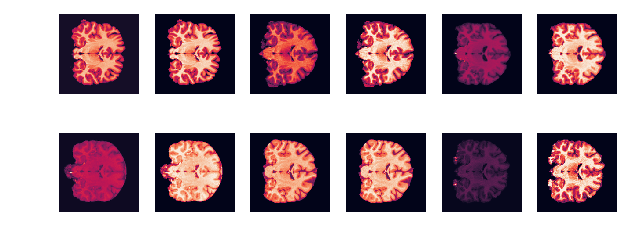

In [110]:
categories = [each for each in os.listdir('registration') if not each.startswith('.')][:6]
plt.figure(figsize=(10,4))
raw_list = []
normalised_list = []
slice_list = []
normalised_slice_list = []
for n,category in enumerate(categories):
    category_path = os.path.join('registration',category)
    full_path = os.path.join(category_path,os.listdir(category_path)[0])
    proxy = nib.load(full_path)
    normalised_proxy = gmm.gmm_normalize(proxy)
    row = len(categories) // 2
    plt.subplot(2, 6,n*2+1)
    data = np.array(proxy.dataobj)
    slice = data[:,108,:]
    normalised_data = np.array(normalised_proxy.dataobj)
    normalised_slice = normalised_data[:,108,:]
    normalised_slice[normalised_slice>1.1] = 1.1
    value, grids = np.histogram(slice[slice>1], density=True, bins=np.linspace(0,750,100))
    new_value, new_grid = np.histogram(normalised_slice[normalised_slice>0], density=True, bins=np.linspace(0,1.5,101))
    raw_list.append((value, grids))
    normalised_list.append((new_value, new_grid))
    slice_list.append(slice)
    normalised_slice_list.append(normalised_slice)
    plt.imshow(slice)
    plt.axis('off')
    plt.subplot(2, 6, n*2+2)
    plt.imshow(normalised_slice)
    plt.axis('off')

Text(0.5, 0.98, 'Difference between raw images and normalised images')

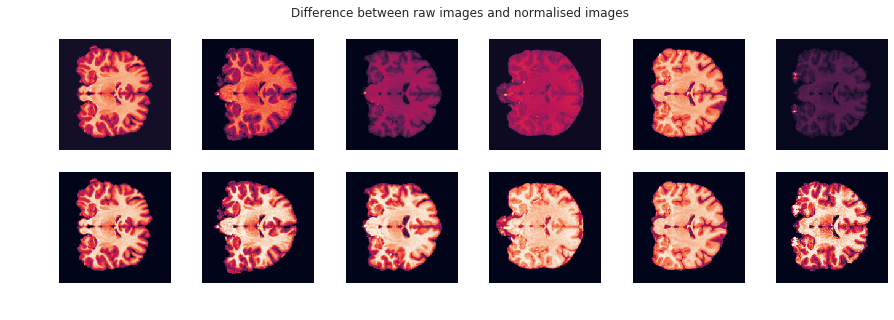

In [126]:
n = 1
plt.figure(figsize=(15,4.5))
for raw,norm in zip(slice_list, normalised_slice_list):
    plt.subplot(2,6,n)
    plt.imshow(raw)
    plt.axis('off')
    plt.subplot(2,6,n+6)
    plt.imshow(norm)
    plt.axis('off')
    n += 1
plt.suptitle('Difference between raw images and normalised images')

In [52]:
sample_pathes = ['registration/Cambridge/sub00156.nii.gz',
                 'registration/Dallas/sub04288.nii.gz',
                 'registration/ICBM/sub00448.nii.gz',]
#                  'registration/IXI/IXI002.nii.gz',
#                  'registration/Leipzig/sub00321.nii.gz',
#                  'registration/Leiden/sub01553.nii.gz']


Text(0.5, 1.0, 'Homemade')

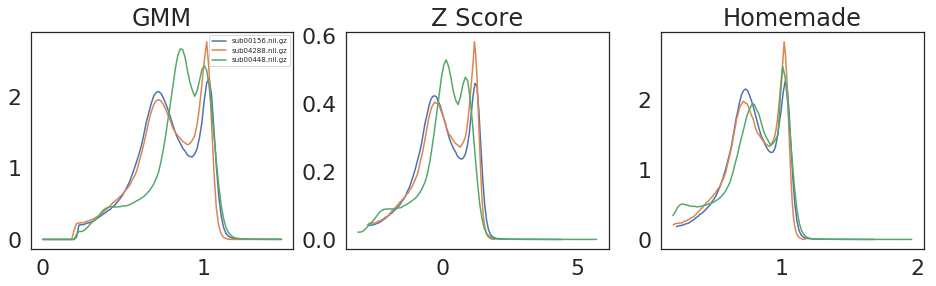

In [55]:
plt.figure(figsize=(16,4))
ax = plt.subplot(1,3,1)
for sample_path in sample_pathes:
    ori_agent = nib.load(sample_path)
    normalised = gmm.gmm_normalize(ori_agent)
    obj = np.array(normalised.dataobj)
    value,axis = np.histogram(obj[obj>obj.mean()],density=True, bins=np.linspace(0,1.5,101),)
    plt.plot(axis[:-1], value,label=sample_path.split('/')[-1])
    plt.legend(fontsize='x-small')
ax.set_title('GMM')

ax = plt.subplot(1,3,2)
for sample_path in sample_pathes:
    ori_agent = nib.load(sample_path)
    normalised = zscore.zscore_normalize(ori_agent)
    obj = np.array(normalised.dataobj)
    value, axis = np.histogram(obj[obj>obj.mean()],density=True,bins=101)
    plt.plot(axis[:-1], value)
ax.set_title('Z Score')

ax = plt.subplot(1,3,3)
for sample_path in sample_pathes:
    ori_agent = nib.load(sample_path)
    normalised = home_made_norm(ori_agent)
    obj = np.array(normalised.dataobj)
    value,axis = np.histogram(obj[obj>obj.mean()],density=True,bins=101)
    plt.plot(axis[:-1], value,)
ax.set_title('Homemade')

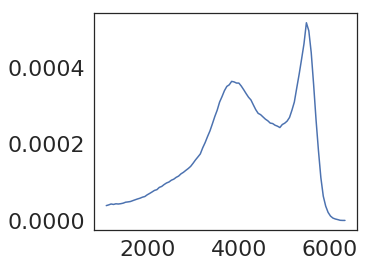

In [64]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
ori_agent = nib.load(sample_pathes[1])
obj = np.array(ori_agent.dataobj)
value,axis = np.histogram(obj[obj>obj.mean()],density=True, bins=100)
plt.plot(axis[:-1],value)


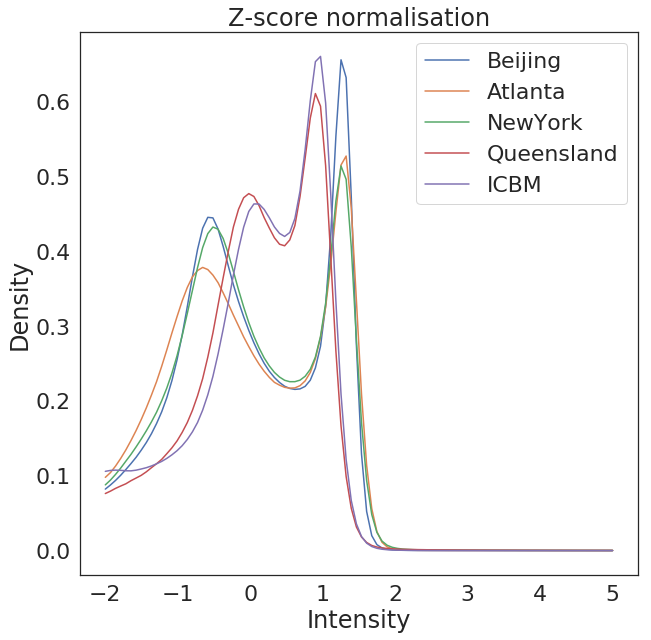

In [84]:
categories = [each for each in os.listdir('registration') if not each.startswith('.')][:5]
plt.figure(figsize=(10,10))
plt.title('Z-score normalisation')
for n,category in enumerate(categories):
    category_path = os.path.join('registration',category)
    file_names = [each for each in os.listdir(category_path) if each.endswith('.gz')]
    category_value = np.zeros(100)
    for file_name in file_names:
        full_path = os.path.join(category_path, file_name)
        proxy = nib.load(full_path)
        result_proxy = zscore.zscore_normalize(proxy)
        data = np.array(result_proxy.dataobj)
        value, grid = np.histogram(data,bins=np.linspace(-2,5,101),density=True)
        category_value += value
    category_value /= len(file_names)
    plt.plot(np.linspace(-2,5,100), category_value,label=category)
plt.xlabel('Intensity')
plt.ylabel('Density')
plt.legend()

In [80]:
np.linspace(-2,5,100).shape

(100,)

Text(0.5, 1.0, 'Z-score normalisation')

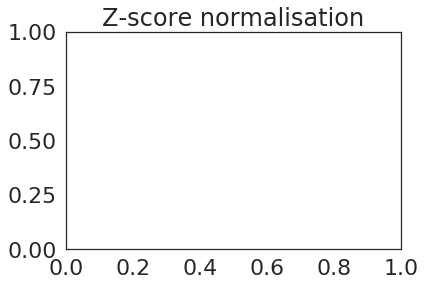